# Required Imports 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/SOLO_data

/content/drive/.shortcut-targets-by-id/117_-VjNmffD0mP9aV959FKbAyUkPPcXk/SOLO_data


In [2]:
# !pip install pytorch_lightning

In [ ]:
from HW4_PartB_Code_Template.pretrained_models import *
from HW4_PartB_Code_Template.BoxHead import *
from HW4_PartB_Code_Template.utils import *
from HW4_PartB_Code_Template.train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
plt.rcParams["figure.figsize"] =(5,5)

# Dataset and DataLoaders Creating 

In [4]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"

paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 16
print("batch size:", batch_size)

train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()


Image  (3265, 3, 300, 400) 
Mask  3265 
Labels  (3265,) 
BBox  (3265,)
batch size: 16


# Plot the proposed boxes - along with ground truth

In [ ]:
# Put the path were you save the given pretrained model
pretrained_path='HW4_PartB_Code_Template/checkpoint680.pth'
backbone, rpn = pretrained_models_680(pretrained_path)

# Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
keep_topK=20

with torch.no_grad():
    for iter, batch in enumerate(test_loader, 0):
        images = batch['images'].to(device)

        # Take the features from the backbone
        backout = backbone(images)
        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())
        break

In [ ]:
faster_rcnn = BoxHead()

In [ ]:
labels,regressor_target = faster_rcnn.create_ground_truth(proposals,batch['labels'],batch['bbox'])
labels.shape,regressor_target.shape 

(torch.Size([2000]), torch.Size([2000, 4]))

In [ ]:
feature_vectors = faster_rcnn.MultiScaleRoiAlign(fpn_feat_list,proposals)
class_logits, box_pred = faster_rcnn.forward(feature_vectors)
class_logits.shape, box_pred.shape 

(torch.Size([2000, 4]), torch.Size([2000, 12]))

In [ ]:
# For some images plot the proposals that are assigned to a no-background class along with their corresponding ground truth box.
indices = torch.where(labels>0)[0] 
image_bounding_boxes_map = torch.div(indices, keep_topK, rounding_mode='trunc')

decoded = output_decoding(regressor_target,proposals)
proposal = torch.vstack(proposals).clone()
decoded[indices].shape 

torch.Size([94, 4])

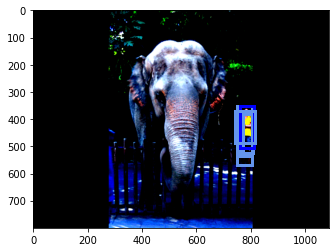

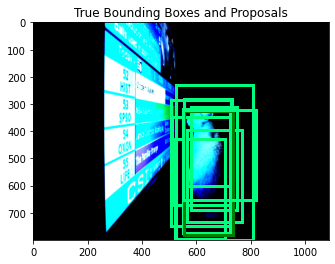

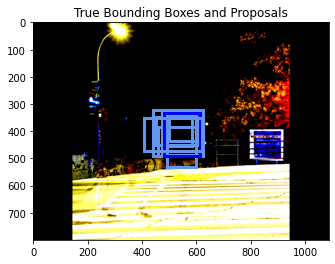

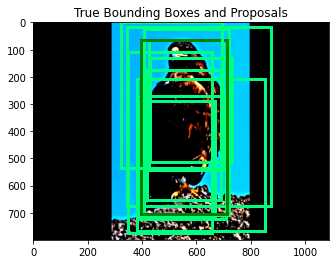

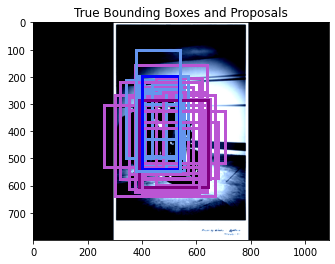

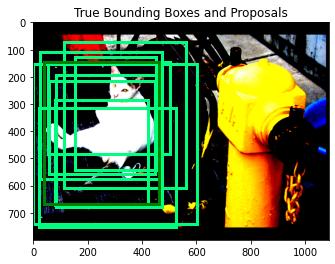

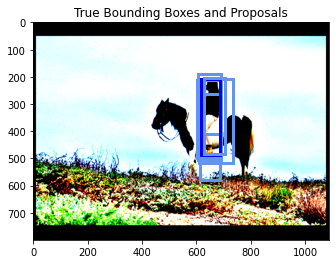

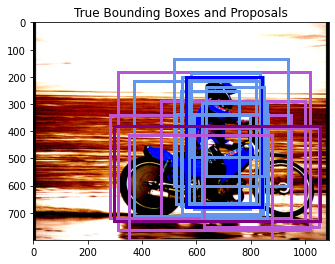

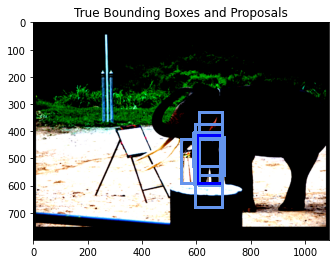

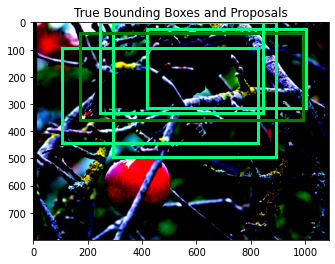

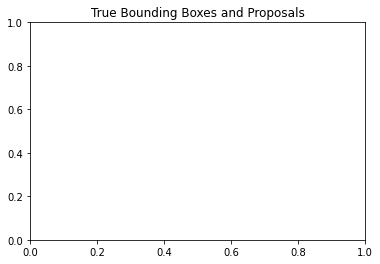

In [ ]:
plot_anchors(batch['images'],proposal[indices],decoded[indices],labels[indices],image_bounding_boxes_map)

# Training the model 

In [13]:
# model = TrainModel().load_from_checkpoint('/content/drive/MyDrive/SOLO_data/fasterrcnn-epochepoch=08-lossval_loss=0.39.ckpt')
model = TrainModel()
model.train()
model.to(device)

## Setup your training
checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor="val_loss",
                                                   save_top_k=10,
                                                   dirpath='/content/drive/MyDrive/SOLO_data/',
                                                   filename='fasterrcnn-epoch{epoch:02d}-loss{val_loss:.2f}'
                                                   )
tb_logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/SOLO_data/log/")

In [5]:
# Train your model
trainer = pl.Trainer(gpus=1, max_epochs=15)
# trainer.fit(model, train_loader, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


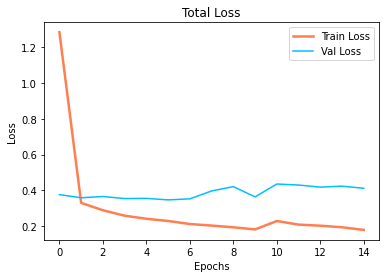

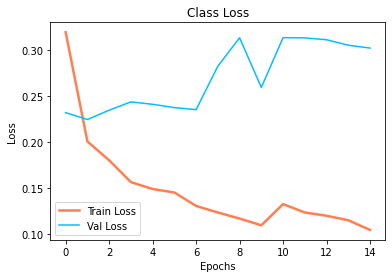

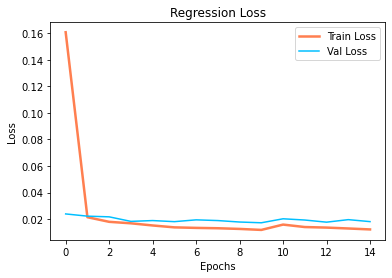

In [ ]:
model.loss_plots()

# Predictions - Code and Plot  

In [6]:
model_path = '/content/drive/MyDrive/SOLO_data/fasterrcnn-epochepoch=05-lossval_loss=0.32.ckpt'

In [7]:
model = TrainModel().load_from_checkpoint(model_path)
model.to(device)
model.eval()

TrainModel(
  (faster_rcnn): BoxHead(
    (intermediate_layer): Sequential(
      (0): Linear(in_features=12544, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
    )
    (classifier_layer): Sequential(
      (0): Linear(in_features=1024, out_features=4, bias=True)
    )
    (regressor_layer): Sequential(
      (0): Linear(in_features=1024, out_features=12, bias=True)
    )
    (class_loss): CrossEntropyLoss()
    (regressor_loss): SmoothL1Loss()
  )
)

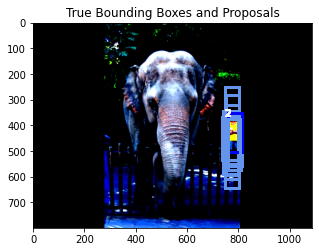

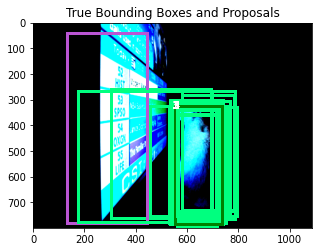

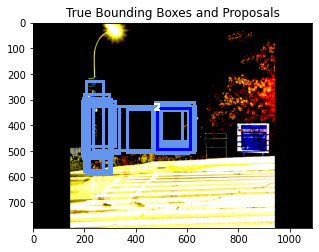

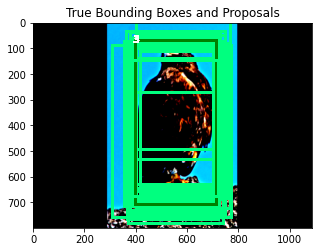

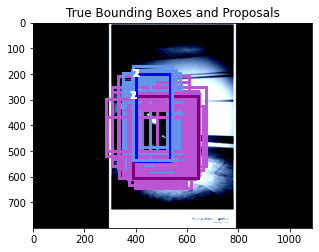

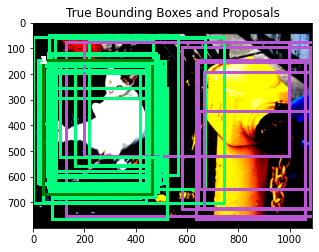

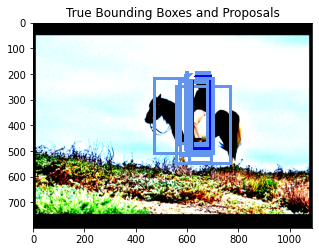

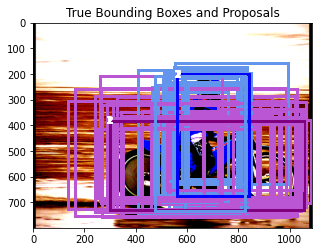

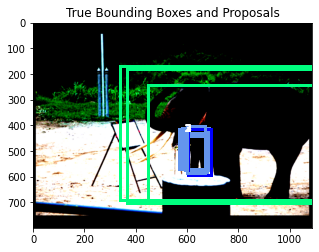

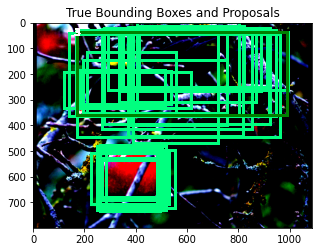

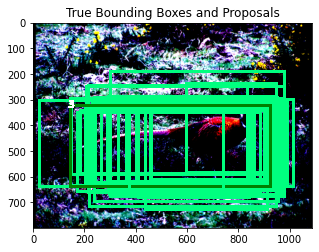

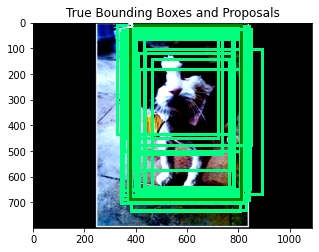

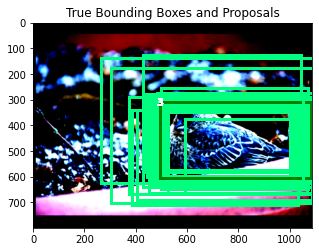

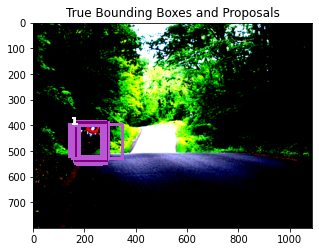

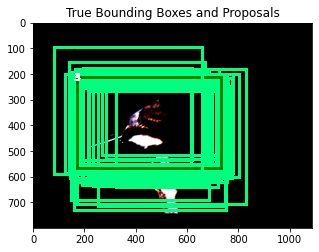

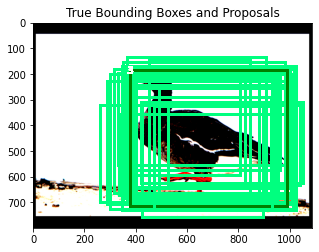

In [10]:
with torch.no_grad():
    batch = next(iter(test_loader))
    images, labels, _, bboxes, _  = batch.values() 
    prediction = model(batch)

    conf_score,pred_labels = torch.max(F.softmax(prediction['class_logits'],dim=1),dim=1)

    indices = torch.where(prediction['labels']>0)
    print("Total Class Accuracy\t\t: ",np.round((torch.where(pred_labels==prediction['labels'],1,0).sum()/len(pred_labels)*100).item(),2))
    print("No Background - Class Recall\t: ",np.round((torch.where(prediction['labels'][indices] == pred_labels[indices],1,0).sum()/len(indices[0])).item()*100,2))
    indices = torch.where(pred_labels>0)
    print("No Background - Class Precision\t: ",np.round((torch.where(prediction['labels'][indices] == pred_labels[indices],1,0).sum()/len(indices[0])).item()*100,2))

    pos_indices = torch.where(pred_labels>0)[0]
    all_indices = (pred_labels[pos_indices].reshape(-1,1)-1)*4
    all_indices = torch.hstack((all_indices,all_indices+1,all_indices+2,all_indices+3))
    box_pred = prediction['box_pred'][pos_indices]
    box_pred = output_decoding(torch.stack([box_pred[i][all_indices[i]] for i in range(len(pos_indices))]),torch.vstack(prediction['proposals'])[pos_indices], device=device)
    gt_box_pred = output_decoding(prediction['regressor_target'][pos_indices],torch.vstack(prediction['proposals'])[pos_indices], device=device)
    
    keep_topK = 200
    image_index = torch.div(pos_indices, keep_topK, rounding_mode='trunc')
    plot_anchors(images,box_pred,gt_box_pred,pred_labels[pos_indices].cpu().detach().numpy(),image_index)

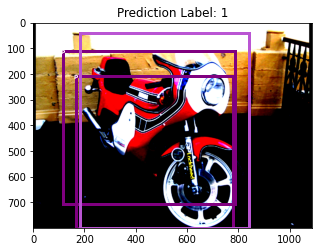

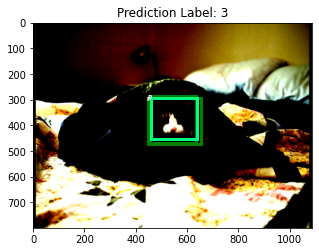

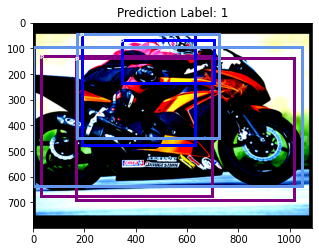

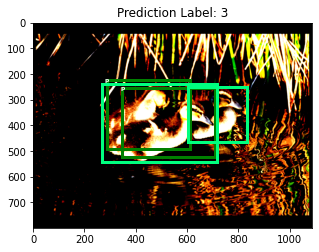

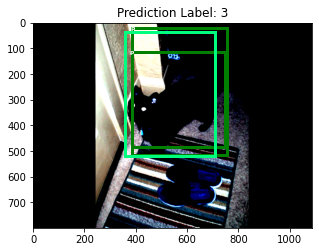

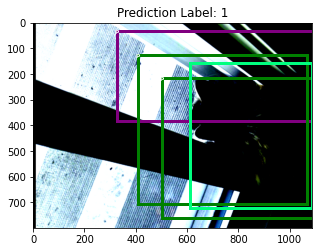

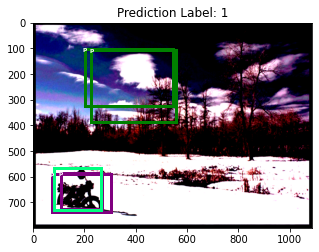

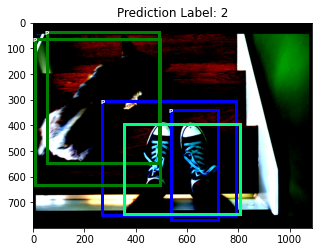

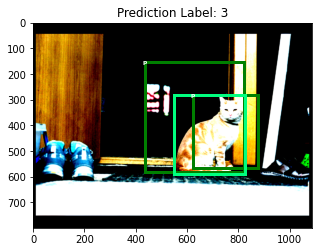

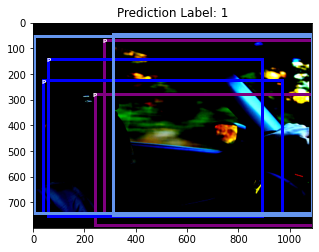

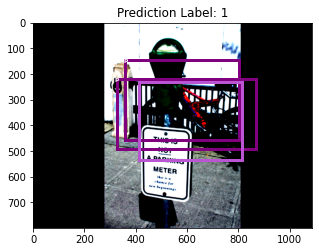

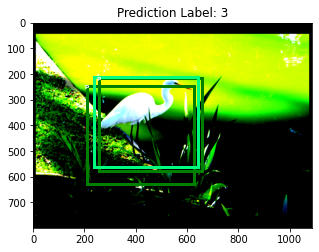

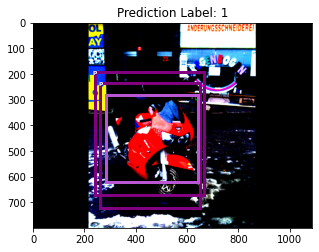

In [23]:
final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction, keep_num_postNMS=2)
plot_predictions(images,final_pred,final_label,bboxes)

In [ ]:
pred = []
target = []
c_p = []
c_l = []
for idx,batch in enumerate(test_loader):
    print(idx)
    with torch.no_grad():
        images, labels, _, bboxes, _  = batch.values() 
        prediction = model(batch)
        final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction,keep_num_preNMS=50, keep_num_postNMS=3)
        # pred.extend([dict(boxes=final_pred[i],scores=final_conf[i],labels=final_label[i].to(device)) for i in range(len(final_conf))])
        # target.extend([dict(boxes=bboxes[i].to(device),labels=labels[i].to(device)) for i in range(len(final_conf))])
        pred.extend({final_pred,final_conf,final_label})
        target.extend(bboxes,labels)
        c_p.extend([prediction['class_logits']])
        c_l.extend(prediction['labels'])
results(target,pred)

### Create Hold out Predictions 

In [4]:
# Put the path were the given hold_out_images.npz file is save and load the images
hold_images_path='data/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']


# Put the path were you have your save network
train_model_path='fasterrcnn-epochepoch=05-lossval_loss=0.32.ckpt'
# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
model = TrainModel().load_from_checkpoint(train_model_path)
model.to(device)
model.eval()

TrainModel(
  (faster_rcnn): BoxHead(
    (intermediate_layer): Sequential(
      (0): Linear(in_features=12544, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
    )
    (classifier_layer): Sequential(
      (0): Linear(in_features=1024, out_features=4, bias=True)
    )
    (regressor_layer): Sequential(
      (0): Linear(in_features=1024, out_features=12, bias=True)
    )
    (class_loss): CrossEntropyLoss()
    (regressor_loss): SmoothL1Loss()
  )
)

In [ ]:
keep_topK=200

cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_images, 0):
    print(i)
    images = torch.from_numpy(numpy_image).to(device)
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals=[proposal[0:model.keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())
    feature_vectors = model.faster_rcnn.MultiScaleRoiAlign(fpn_feat_list,proposals)
    class_logits, box_pred = model.faster_rcnn.forward(feature_vectors)
    prediction = dict(labels=torch.zeros(len(class_logits)),class_logits=class_logits,regressor_target=box_pred,box_pred=box_pred,proposals=proposals)
    final_pred, final_conf, final_label = model.faster_rcnn.postprocess_detections(prediction, keep_num_postNMS=2)

    for box, score, label in zip(final_pred,final_conf,final_label):
        if box is None:
            cpu_boxes.append(None)
            cpu_scores.append(None)
            cpu_labels.append(None)
        else:
            cpu_boxes.append(box.to('cpu').detach().numpy())
            cpu_scores.append(score.to('cpu').detach().numpy())
            cpu_labels.append(label.to('cpu').detach().numpy())

In [6]:
np.savez('predictions.npz', predictions={'boxes': cpu_boxes, 'scores': cpu_scores,'labels': cpu_labels})